In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
from scipy import interpolate
import PIVutils
import PODutils


saveFolder = '/Users/Owen/Dropbox/Python Codes/ASIIT/Data/'
saveFile = 'RNV45-thumbs.hdf5'
imgFolder = saveFolder + saveFile[:-5]

noEdge = True
interpVecs = True

import os
if not os.path.exists(imgFolder):
    os.makedirs(imgFolder)

In [2]:
import sys
sys.executable

'/Users/Owen/anaconda/bin/python'

In [3]:
PIVutils = reload(PIVutils)
#X, Y, U, V, Swirl = PIVutils.loadDataset('/Users/Owen/Dropbox/Data/ABL/Heat Flux Data/Processed Results/N/Neutral45_2.mat',['X','Y','U','V','Swirl'],[])
#X, Y, U, V, Swirl, Cond, Prof = PIVutils.loadDataset('/Users/Owen/Dropbox/Data/ABL/Heat Flux Data/Processed Results/N/Neutral45.mat',['X','Y','U','V','Swirl'],['Cond','Prof'])
X, Y, U, V, Swirl, Cond, Prof = PIVutils.loadDataset('/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2.mat',\
                                                     ['X','Y','U','V','Swirl'],['Cond','Prof'],matlabData = True)

['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


In [4]:
X = X/Cond["delta"]
Y = Y/Cond["delta"]

In [5]:
frame = 0

In [6]:
NanLocs = np.isnan(Swirl)
uSize = Swirl.shape
scale = (X[1,-1]-X[1,1])/(uSize[1]-1)

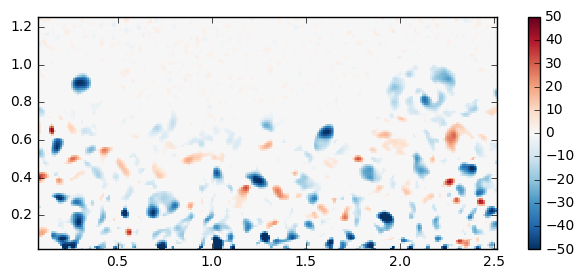

In [7]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(Swirl[:,:,frame]*Cond["delta"]/Cond["Utau"],X,Y,50,saveFolder = (imgFolder + '/Swirl_1.pdf'))

# Interpolate missing vecs if wanted

In [8]:
#reload(PIVutils)
#[f, ax] = PIVutils.plotScalarField(U[:,:,frame]*Cond["delta"]/Cond["Utau"],X,Y,3)

In [9]:
missVecs = np.zeros(U.shape)
missVecs[np.isnan(U)] = 1
PercentMissing = np.zeros(U.shape[2])
for i in range(U.shape[2]):
    PercentMissing[i] = missVecs[:,:,i].sum()/(U.shape[0]*U.shape[1])*100

In [10]:
if interpVecs:
    for i in range(uSize[2]):
        #print(i)
        f = interpolate.interp2d(X[0,:], Y[:,0], U[:,:,i], kind='linear')
        U[:,:,i] = f(X[0,:],Y[:,0])
        f = interpolate.interp2d(X[0,:], Y[:,0], V[:,:,i], kind='linear')
        V[:,:,i] = f(X[0,:],Y[:,0])   
        f = interpolate.interp2d(X[0,:], Y[:,0], Swirl[:,:,i], kind='linear')
        Swirl[:,:,i] = f(X[0,:],Y[:,0]) 

In [11]:
#reload(PIVutils)
#[f, ax] = PIVutils.plotScalarField(U[:,:,frame]*Cond["delta"]/Cond["Utau"],X,Y,3)

# Remove background noise

In [12]:
Noise = np.std(Swirl,axis=(2,1))
Noise = np.std(Noise[-5:])
print(Noise)

0.243960186268


In [13]:
SwirlFilt = Swirl.copy()    #think this should completely copy the list, allowing me to try things

NoiseFilt = 20      # Filter at 20 times rms of freestream swirl 

#Swirl must be above a certain background value or it is zeroed
SwirlFilt[np.absolute(Swirl)<NoiseFilt*Noise] = 0

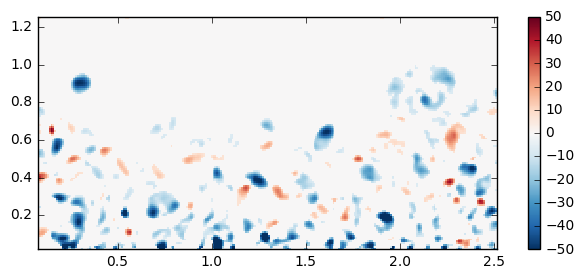

In [14]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame]*Cond["delta"]/Cond["Utau"],X,Y,50,saveFolder = (imgFolder + '/Swirl_2.pdf'))

# Normalize field by std

In [15]:
SwirlStd = np.std(Swirl,axis=(2,1))
#print(SwirlStd)

In [16]:
#Normalize field by the std of Swirl
SwirlFilt = SwirlFilt/SwirlStd.reshape(uSize[0],1,1) #match the SwirlStd length (123) with the correct index in Swirl (also 123)

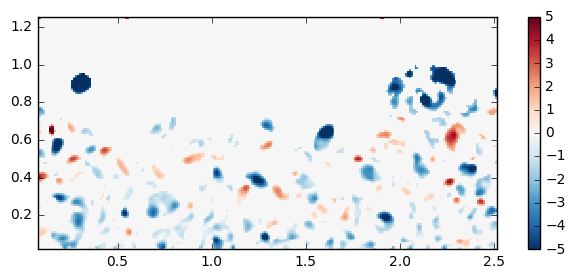

In [17]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],X,Y,5,saveFolder = (imgFolder + '/Swirl_3.pdf'))

In [18]:
SwirlFiltBackup = SwirlFilt.copy()

# Create thresholded field

In [19]:
SwirlFilt = SwirlFiltBackup.copy()    #think this should completely copy the list, allowing me to try things

#Then only keep those locations where swirls is greater than Thresh*SwirlStd
ThreshSTD = 1.5
SwirlFilt[np.absolute(SwirlFilt)<ThreshSTD] = 0
SwirlFiltPro = SwirlFilt.copy()
SwirlFiltPro[SwirlFiltPro>0] = 0
SwirlFiltRet = SwirlFilt.copy()
SwirlFiltRet[SwirlFiltRet<0] = 0

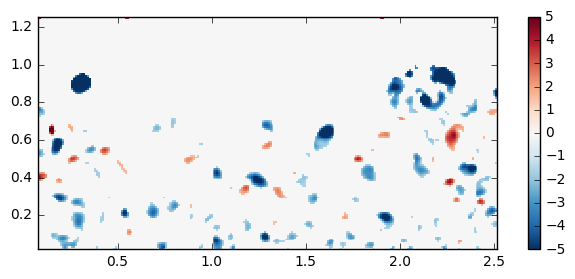

In [20]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],X,Y,5,saveFolder = (imgFolder + '/Swirl_4.pdf'))

# Find all blobs and filter for size


In [21]:
BoxSize = 10

if noEdge:
    EdgeBound =  BoxSize
else:
    EdgeBound = None

PIVutils = reload(PIVutils)
ThreshPro = 35    #30 or 35 cause bug
[num_features_Pro,features_per_frame_Pro, labeled_array_Pro, cent_Pro] = PIVutils.findBlobs(SwirlFiltPro,ThreshPro,EdgeBound = EdgeBound)

ThreshRet = 20    #30 or 35 cause bug
[num_features_Ret,features_per_frame_Ret, labeled_array_Ret, cent_Ret] = PIVutils.findBlobs(SwirlFiltRet,ThreshRet,EdgeBound = EdgeBound)

There are  76730  features identified
A total of  13188  are larger than the threshold size
Of these 10645  are far enough away from edge of domain
There are  27229  features identified
A total of  3924  are larger than the threshold size
Of these 3489  are far enough away from edge of domain


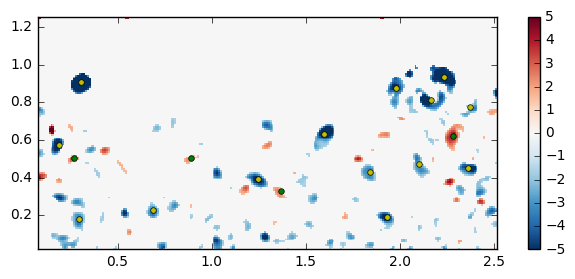

In [22]:
reload(PIVutils)
[f, ax] = PIVutils.plotScalarField(SwirlFilt[:,:,frame],X,Y,5)

for i in range(features_per_frame_Pro[frame]):
    plt.plot(cent_Pro[frame][i][1]*scale+X[1,1],cent_Pro[frame][i][0]*scale+Y[1,1],'oy',markersize=4,markeredgecolor=None)
    
for i in range(features_per_frame_Ret[frame]):
    plt.plot(cent_Ret[frame][i][1]*scale+X[1,1],cent_Ret[frame][i][0]*scale+Y[1,1],'og',markersize=4,markeredgecolor=None)
    
f.savefig(imgFolder + '/Swirl_5.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

# Get thumbnails (Box = 21x21)

In [23]:
reload(PIVutils)

Ut, Vt, St, missVecs_Pro = PIVutils.getThumbnails2D([U,V,Swirl,missVecs],cent_Pro,BoxSize)
Ur, Vr, Sr, missVecs_Ret = PIVutils.getThumbnails2D([U,V,Swirl,missVecs],cent_Ret,BoxSize)

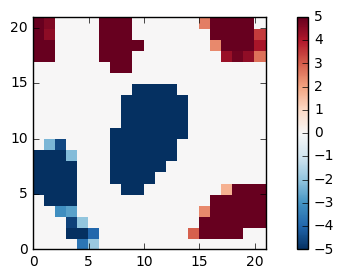

In [24]:
[f, ax] = PIVutils.plotScalarField(St[:,:,0],bound=5)

# Save thumbnails

In [25]:
ThumbParams = {"interpVecs":(interpVecs,),\
               "noEdge":(noEdge,),\
               "NoiseFilt":(NoiseFilt,),\
               "ThreshSTD":(ThreshSTD,),\
               "BoxSize":(BoxSize,),\
               "ThreshPro":(ThreshPro,),\
               "ThreshRet":(ThreshRet,),
               "num_features_Pro": (num_features_Pro,),\
               "num_features_Ret": (num_features_Ret,)}

Xfull = X;
Yfull = Y;
x = X[0,0:BoxSize+1]
y = Y[0:BoxSize+1,0]
x = x-x[0]
x2 = np.flipud(x)
y = y-y[0]
y2 = np.flipud(y)
x = np.concatenate((-1*x2, x[1:]))
y = np.concatenate((-1*y2, y[1:]))
x[BoxSize] = 0
y[BoxSize] = 0

del x2, y2

X, Y = np.meshgrid(x, y)

In [48]:
Yind_Pro = np.zeros(Ut.shape[2])
Ypos_Pro = np.zeros(Ut.shape[2])

thumb=0
for i in range(len(cent_Pro)):
    for j in range(len(cent_Pro[i])):
        Yind_Pro[thumb] = cent_Pro[i][j][0]
        Ypos_Pro[thumb] = Yfull[cent_Pro[i][j][0],0]
        thumb+=1
        
Yind_Ret = np.zeros(Ur.shape[2])  
Ypos_Ret = np.zeros(Ur.shape[2])

thumb=0
for i in range(len(cent_Ret)):
    for j in range(len(cent_Ret[i])):
        Yind_Ret[thumb] = cent_Ret[i][j][0]
        Ypos_Ret[thumb] = Yfull[cent_Ret[i][j][0],0]
        thumb+=1

In [49]:
reload(PIVutils)
PIVutils.saveDataset(saveFolder + saveFile,\
                    ['X','Y','x','y','U','V','S','missVecs','Yind_Pro','Ypos_Pro','Ur','Vr','Sr','missVecs_Ret','Yind_Ret','Ypos_Ret','Yvec'],\
                     [X,Y,x,y,Ut,Vt,St,missVecs_Pro,Yind_Pro,Ypos_Pro,Ur,Vr,Sr,missVecs_Ret,Yind_Ret,Ypos_Ret,Yfull[:,0]],\
                     ['Cond','Prof','ThumbParams'],[Cond,Prof,ThumbParams])

Delete original file (default: no) [y/N] y
Original file deleted
File saved


In [28]:
#del Prof

In [40]:
#X,Y,x,y,U,V,S,missVecs_Pro,Yind_Pro,Ur,Vr,Sr,missVecs_Ret,Yind_Ret,Cond,Prof,ThumbParams = \
#                        PIVutils.loadDataset(saveFolder + saveFile,
#                         ['X','Y','x','y','U','V','S','missVecs','Yind_Pro','Ur','Vr','Sr','missVecs_Ret','Yind_Ret'], 
#                         ['Cond','Prof','ThumbParams'])

In [41]:
#Prof['U']

In [42]:
#Y[:,0]